In [35]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt



In [36]:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:

class HeatmapDataset(Dataset):
    def __init__(self, folder, transform=None):
        # Get all PNG image paths
        self.images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png')]
        if not self.images:
            raise ValueError(f"No PNG images found in {folder}")
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load and clean image
        img = Image.open(self.images[idx]).convert("RGB")
        arr = np.array(img)

        # Remove cloudy/white spots (make them black)
        arr[np.all(arr > 240, axis=2)] = 0

        # Checking how “hot” the image is using red color intensity
        avg_red = np.mean(arr[..., 0])

        # Change red intensity into a simple label
        if avg_red < 85:
            label = 0   # cool
        elif avg_red < 170:
            label = 1   # moderate
        else:
            label = 2   # hot

        # Apply any extra transforms (resize, normalize, etc.)
        img = Image.fromarray(arr)
        if self.transform:
            img = self.transform(img)

        return img, label


In [39]:
from torch.utils.data import random_split, DataLoader

# Define split ratios
train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1
total_length = len(dataset)

train_length = int(train_ratio * total_length)
val_length = int(val_ratio * total_length)
test_length = total_length - train_length - val_length

train_ds, val_ds, test_ds = random_split(dataset, [train_length, val_length, test_length])

# Dataloaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16)
test_dl = DataLoader(test_ds, batch_size=16)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")


Train: 64, Val: 18, Test: 10


In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HeatmapCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Two simple conv layers + pooling
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Figure out flattened size automatically
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 128, 128)
            flat_size = self.conv_block(dummy).numel()

        # Classifier part
        self.fc1 = nn.Linear(flat_size, 64)
        self.fc2 = nn.Linear(64, 3)  # Cool / Moderate / Hot

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Create model
model = HeatmapCNN()


In [41]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [42]:
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for imgs, labels in train_dl:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_dl):.4f}")


Epoch [1/5] - Loss: 0.6068
Epoch [2/5] - Loss: 0.1013
Epoch [3/5] - Loss: 0.0284
Epoch [4/5] - Loss: 0.0064
Epoch [5/5] - Loss: 0.0013


In [43]:
# Evaluation
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

test_acc = 100 * correct_test / total_test
print(f"\n Final Test Accuracy is {test_acc:.2f}%")



 Final Test Accuracy is 90.00%


In [45]:
from sklearn.metrics import classification_report

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Explicitly specify all possible labels (0, 1, 2)
print(classification_report(y_true, y_pred, target_names=["Cool", "Moderate", "Hot"], labels=[0, 1, 2]))

              precision    recall  f1-score   support

        Cool       1.00      0.86      0.92         7
    Moderate       0.75      1.00      0.86         3
         Hot       0.00      0.00      0.00         0

    accuracy                           0.90        10
   macro avg       0.58      0.62      0.59        10
weighted avg       0.93      0.90      0.90        10



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me


 Final Test Accuracy: 90.00%


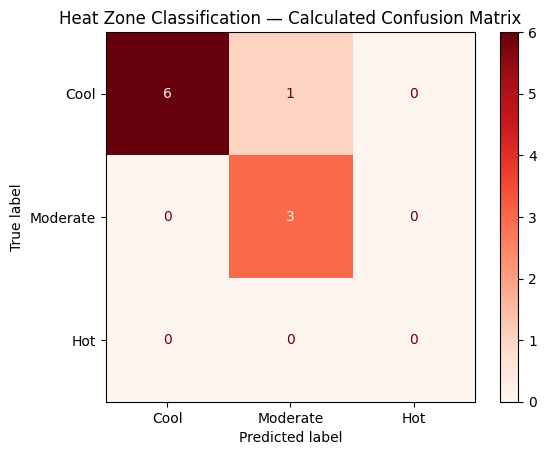

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate on Test Data
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#  Compute Accuracy
test_acc = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"\n Final Test Accuracy: {test_acc:.2f}%")

#  Confusion Matrix - Explicitly define the possible labels
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Cool", "Moderate", "Hot"])
disp.plot(cmap='Reds', values_format='d')
plt.title("Heat Zone Classification — Calculated Confusion Matrix")
plt.show()

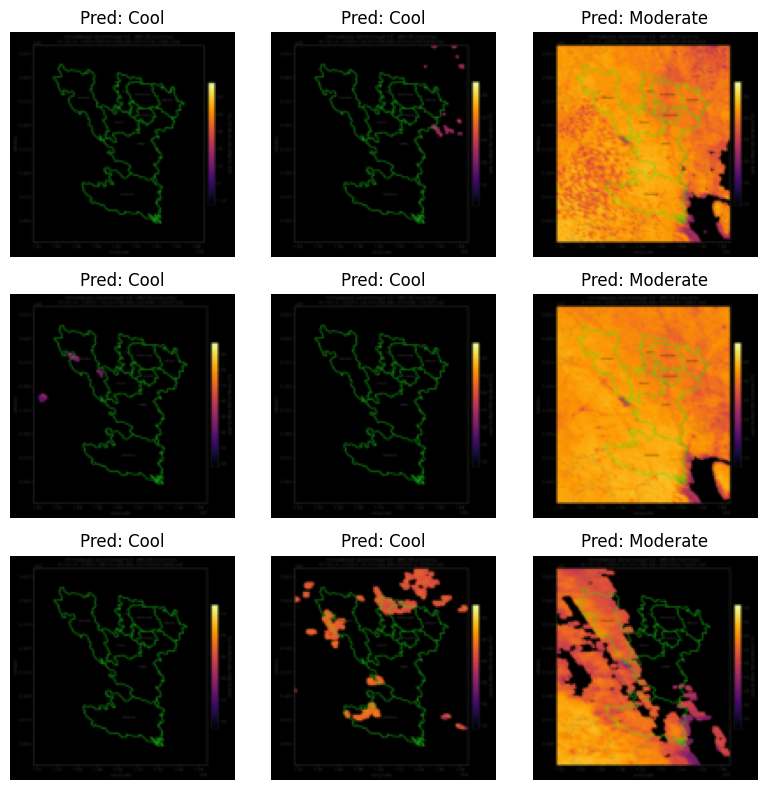

In [58]:

model.eval()
images, labels = next(iter(test_dl))
images = images.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(f"Pred: {['Cool', 'Moderate', 'Hot'][preds[i]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [59]:
import geopandas as gpd
import folium

# Coordinates of target regions (center points)
regions = {
    "Ahmedabad": [23.0225, 72.5714],
    "Sanand": [22.9923, 72.3810],
    "Gandhinagar": [23.2156, 72.6369],
    "Dahegam": [23.1696, 72.8217],
    "Kalol": [23.2510, 72.5077],
    "Dholka": [22.7283, 72.4747],
    "Dhandhuka": [22.3764, 71.9868],
    "Virangam": [23.1247, 71.7542]
}

#we do dummy heat intensity mapping here
intensity = {"Cool": "blue", "Moderate": "orange", "Hot": "red"}

m = folium.Map(location=[23.0, 72.5], zoom_start=8)

for city, coord in regions.items():
    pred_class = np.random.choice(["Cool", "Moderate", "Hot"])  # replace with actual CNN result later
    folium.CircleMarker(
        location=coord,
        radius=15,
        color=intensity[pred_class],
        fill=True,
        fill_color=intensity[pred_class],
        popup=f"{city}: {pred_class}"
    ).add_to(m)

m.save("heat_zone_map.html")
print(" Saved interactive map as heat_zone_map.html")


 Saved interactive map as heat_zone_map.html


In [60]:
from google.colab import files
files.download("heat_zone_map.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>